In [13]:
# 셀 2: 라이브러리 불러오기 + Tesseract 경로 설정

import cv2
import numpy as np
import mss
from PIL import Image
import pyperclip
import pytesseract
import pandas as pd
from matplotlib import pyplot as plt

# ⚠️ 본인 PC의 Tesseract 설치 경로로 바꿔 주세요.
# 보통 아래 둘 중 하나입니다.
#   - C:\Program Files\Tesseract-OCR\tesseract.exe
#   - C:\Program Files (x86)\Tesseract-OCR\tesseract.exe

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

print("라이브러리 로드 및 Tesseract 경로 설정 완료")



라이브러리 로드 및 Tesseract 경로 설정 완료


전체 화면 캡쳐 완료! img.shape = (1080, 1920, 3)


c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtool

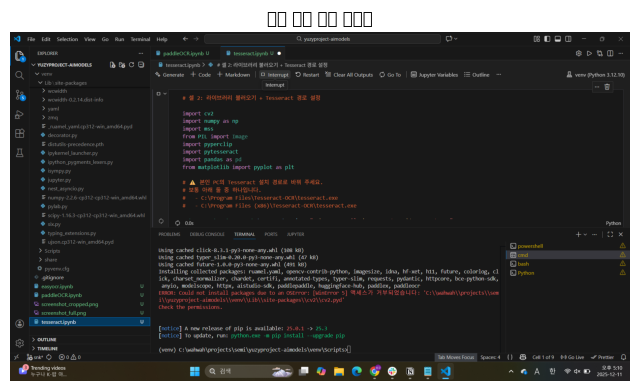

In [14]:
# 셀 3: 전체 화면 캡쳐

with mss.mss() as sct:
    monitor = sct.monitors[1]  # 1번 모니터 전체
    screenshot = sct.grab(monitor)

# mss → numpy 배열(OpenCV 포맷)
img = np.array(screenshot)

# BGRA → BGR 변환
img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

print("전체 화면 캡쳐 완료! img.shape =", img.shape)

# 화면이 어떻게 캡쳐됐는지 눈으로 확인
plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("전체 화면 캡쳐 이미지")
plt.show()



In [15]:
# 셀 4-1: Tkinter로 ROI 선택하는 함수 정의

import tkinter as tk
from PIL import Image, ImageTk

def select_roi_with_tk(bgr_img):
    """
    BGR 이미지를 받아서 Tkinter 창에 띄우고,
    마우스로 드래그해서 선택한 영역을 잘라 반환합니다.
    
    return: (cropped_img, (x1, y1, x2, y2))
    """

    # OpenCV BGR → RGB → Pillow 이미지
    rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb)
    w, h = pil_img.size

    # Tkinter 윈도우 생성
    root = tk.Tk()
    root.title("마우스로 드래그해서 영역 선택 (Enter 또는 Esc로 종료)")

    canvas = tk.Canvas(root, width=w, height=h)
    canvas.pack()

    tk_img = ImageTk.PhotoImage(pil_img)
    canvas.create_image(0, 0, anchor="nw", image=tk_img)

    rect = None
    start_x = start_y = 0

    # 선택 결과 저장용
    roi = {"x1": 0, "y1": 0, "x2": w, "y2": h}

    def on_button_press(event):
        nonlocal start_x, start_y, rect
        start_x, start_y = event.x, event.y
        # 기존 사각형 있으면 삭제
        if rect is not None:
            canvas.delete(rect)
        rect = canvas.create_rectangle(start_x, start_y, start_x, start_y,
                                       outline="red", width=2)

    def on_move(event):
        nonlocal rect
        # 드래그하면서 사각형 갱신
        if rect is not None:
            canvas.coords(rect, start_x, start_y, event.x, event.y)

    def on_button_release(event):
        # 마우스를 뗐을 때 최종 좌표 저장
        x_end, y_end = event.x, event.y
        roi["x1"] = min(start_x, x_end)
        roi["y1"] = min(start_y, y_end)
        roi["x2"] = max(start_x, x_end)
        roi["y2"] = max(start_y, y_end)
        print(f"선택된 영역: ({roi['x1']}, {roi['y1']}) → ({roi['x2']}, {roi['y2']})")

    def on_key(event):
        # Enter 또는 Esc 누르면 창 닫기
        if event.keysym in ("Return", "Escape"):
            root.destroy()

    canvas.bind("<ButtonPress-1>", on_button_press)
    canvas.bind("<B1-Motion>", on_move)
    canvas.bind("<ButtonRelease-1>", on_button_release)
    root.bind("<Key>", on_key)

    # 여기서 Tkinter 이벤트 루프가 돌면서 사용자가 드래그 할 수 있습니다.
    root.mainloop()

    # 창이 닫힌 뒤, 좌표로 실제 crop 수행
    x1 = max(0, min(w - 1, roi["x1"]))
    x2 = max(0, min(w,     roi["x2"]))
    y1 = max(0, min(h - 1, roi["y1"]))
    y2 = max(0, min(h,     roi["y2"]))

    if x2 <= x1 or y2 <= y1:
        print("⚠️ 유효한 영역이 선택되지 않았습니다. (기본값 사용)")
        return None, (0, 0, 0, 0)

    cropped_img = bgr_img[y1:y2, x1:x2]
    return cropped_img, (x1, y1, x2, y2)


최종 크롭 좌표: (0, 0, 1920, 1080)
cropped.shape = (1080, 1920, 3)


c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53469 (\N{HANGUL SYLLABLE TAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabto

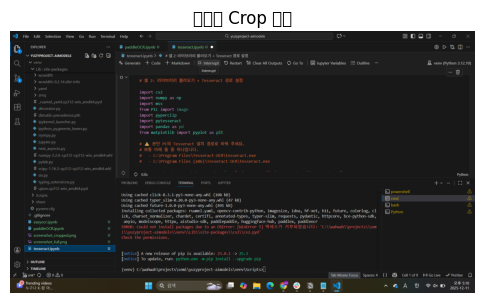

In [16]:
# 셀 4-2: Tkinter ROI 선택 함수 호출해서 cropped 만들기

if 'img' not in globals() or img is None:
    raise RuntimeError("img가 없습니다. 셀 3(전체 화면 캡쳐)을 먼저 실행해 주세요.")

cropped, roi_coords = select_roi_with_tk(img)

if cropped is None:
    print("영역이 제대로 선택되지 않았습니다. 다시 시도해 주세요.")
else:
    print("최종 크롭 좌표:", roi_coords)
    print("cropped.shape =", cropped.shape)

    # 노트북 안에서 한 번 보여주기
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("선택한 Crop 영역")
    plt.show()


In [17]:
# 셀 5: Tesseract 결과로부터 들여쓰기 복구 함수 정의

from pytesseract import Output

def tesseract_indent(df, space_width=20, line_gap=20):
    """
    Tesseract image_to_data() 결과 DataFrame(df)을 받아
    각 단어의 (left, top) 좌표를 이용해 들여쓰기를 복원한 텍스트를 만듭니다.

    :param df: pytesseract.image_to_data(..., output_type=Output.DATAFRAME)의 결과
    :param space_width: 스페이스 1칸에 해당하는 픽셀 수 (환경에 따라 조정)
    :param line_gap: y 중심값 차이가 이 값보다 크면 "새 줄"로 간주
    """
    if df.empty:
        return ""

    # 1. y_center(줄 위치) 계산
    df = df.copy()
    df["y_center"] = df["top"] + df["height"] / 2

    # y_center 기준으로 정렬 (위에서 아래로)
    df = df.sort_values(by="y_center").reset_index(drop=True)

    # 2. y_center 차이를 보고 줄 나누기
    lines = []
    current = [df.iloc[0]]
    prev_y = df.iloc[0]["y_center"]

    for i in range(1, len(df)):
        row = df.iloc[i]
        if abs(row["y_center"] - prev_y) > line_gap:
            lines.append(current)
            current = []
        current.append(row)
        prev_y = row["y_center"]

    if current:
        lines.append(current)

    # 3. 전체에서 가장 왼쪽 x (min_x) 찾기 - 들여쓰기 0 기준
    min_x = min(min(r["left"] for r in line) for line in lines)

    final_text = ""

    # 4. 각 줄마다 들여쓰기 계산 + 줄 텍스트 조합
    for line in lines:
        # 한 줄 내 단어들을 left 기준으로 정렬 (왼쪽→오른쪽)
        line_sorted = sorted(line, key=lambda r: r["left"])

        # 이 줄에서 가장 왼쪽 단어의 x
        line_left = min(r["left"] for r in line_sorted)
        indent_px = line_left - min_x
        indent_spaces = max(0, int(indent_px / space_width))

        indent_str = " " * indent_spaces

        # 단어들을 공백으로 이어붙이기
        line_str = " ".join(str(r["text"]) for r in line_sorted)

        final_text += indent_str + line_str + "\n"

    return final_text

print("들여쓰기 복구 함수(tesseract_indent) 정의 완료")




들여쓰기 복구 함수(tesseract_indent) 정의 완료


c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


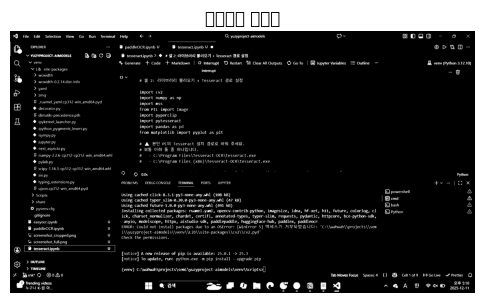

In [ ]:
# 셀 6: 크롭된 이미지(cropped)에 Tesseract 적용 + 들여쓰기 복구

if 'cropped' not in globals() or cropped is None:
    raise RuntimeError("cropped 이미지가 없습니다. 셀 4까지 먼저 실행해 주세요.")

# 1) 전처리 함수 정의
def preprocess_for_ocr(bgr_img, scale=2):
    """
    OCR 전에 이미지 상태를 '글자가 잘 보이게' 만드는 전처리:
    - 그레이스케일
    - 확대
    - 살짝 블러
    - OTSU 이진화
    """
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

    # 확대 (글자가 작을수록 확대하는 게 좋습니다)
    h, w = gray.shape
    gray = cv2.resize(gray, (w * scale, h * scale), interpolation=cv2.INTER_CUBIC)

    # 노이즈 살짝 제거
    gray = cv2.medianBlur(gray, 3)

    # OTSU 이진화
    _, thresh = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresh

# 2) 전처리 실행
pre_img = preprocess_for_ocr(cropped, scale=2)

plt.figure(figsize=(6, 4))
plt.imshow(pre_img, cmap="gray")
plt.axis("off")
plt.title("전처리된 이미지")
plt.show()

# 3) Tesseract에서 단어별 좌표 + 텍스트 추출
# --oem 3 : LSTM 엔진
# --psm 6 : '여러 줄로 된 일반적인 블록 텍스트'라고 가정
config = r'--oem 3 --psm 6'

data = pytesseract.image_to_data(
    pre_img,
    lang="kor+eng",      # 한글+영어 혼합
    config=config,
    output_type=pytesseract.Output.DATAFRAME
)

# 4) 유효한 텍스트만 필터링
df = data[(data.conf != -1) & (data.text.notnull())]
df = df[df.text.str.strip() != ""].reset_index(drop=True)

print("인식된 단어 개수:", len(df))

# 5) 좌표 기반 들여쓰기 복구
# space_width, line_gap은 필요에 따라 조정하면서 맞추시면 됩니다.
final_text = tesseract_indent(df, space_width=20, line_gap=20)

print("=== 들여쓰기 복구된 Tesseract 결과 ===")
print(final_text)
print("=====================================")



In [ ]:
# 셀 7: 최종 텍스트를 클립보드로 복사

if 'final_text' not in globals():
    raise RuntimeError("final_text 변수가 없습니다. 셀 6까지 먼저 실행해 주세요.")

pyperclip.copy(final_text)
print("✅ 들여쓰기 복구된 텍스트를 클립보드에 복사했습니다. 이제 Ctrl+V로 붙여넣기 하시면 됩니다.")


✅ 들여쓰기 복구된 텍스트를 클립보드에 복사했습니다. 이제 Ctrl+V로 붙여넣기 하시면 됩니다.
